# GAN for Real vs. Fake Image Detection on the Oxford Flower Dataset
In this project, we leverage Generative Adversarial Networks (GANs) to differentiate between real and faked images using the Oxford Flower dataset. Our project pipeline is as follows:



In [1]:
epochs = 500

## Importing Libraries

In [2]:
import tarfile
import urllib.request
import os
import cv2
from skimage import transform

#Disabling TF progress bars for each batch
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout
from keras.optimizers import Adam
from keras.models import load_model
import numpy as np
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Downloading and Preprocessing the Data
First, we ensure that our data is downloaded and preprocessed to a format that can be utilized in our models. If the dataset isn't already downloaded, we download it using wget and unzip it with tar. This dataset includes images in `.jpg` format.

In [3]:
images_have_been_downloaded = True
if not images_have_been_downloaded:
    !wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
    !tar -xzf 102flowers.tgz
    !rm 102flowers.tgz

After downloading the data, we preprocess the images by normalizing pixel values and resizing them to 64x64 pixels. If the images are already preprocessed, we load them directly. If not, we process them and save the results for future runs.

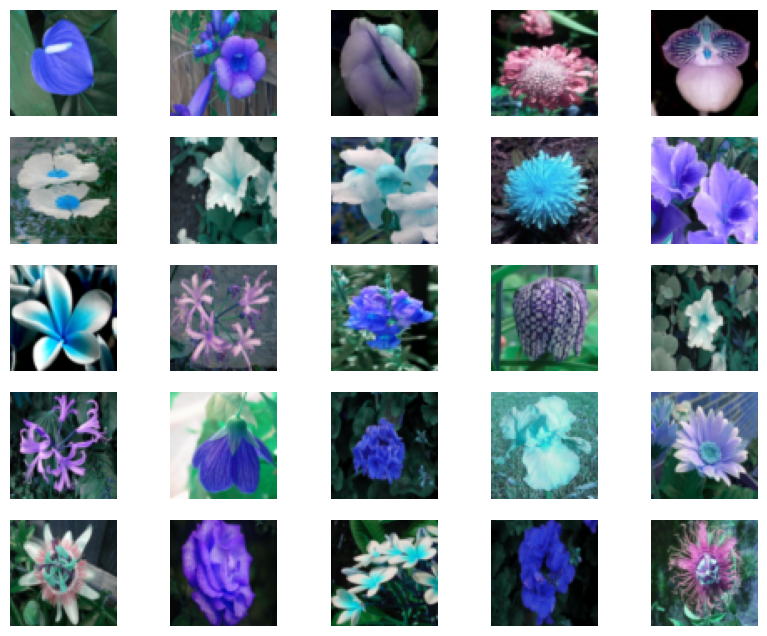

In [4]:
def load_data(directory, size=(64, 64)):
    # Check if preprocessed file already exists
    if os.path.exists('/kaggle/input/processed-oxford-flowers-images'):
        images = np.load('/kaggle/input/processed-oxford-flowers-images/preprocessed_images.npy')
    elif os.path.exists('/kaggle/working/preprocessed_images.npy'):
        images = np.load('/kaggle/working/preprocessed_images.npy')
    else:
        print('Preprocessed file not found. Loading and preprocessing images...')
        images = []
        for file in os.listdir(directory):
            if file.endswith(".jpg"):
                img = cv2.imread(os.path.join(directory, file))
                if img is not None:
                    # Normalize Pixel Values
                    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    # Resize image
                    img = transform.resize(img, size)
                    images.append(img)
        images = np.array(images)
        # Save the preprocessed images for future use
        np.save('preprocessed_images.npy', images)
    return images

images = load_data('/kaggle/working')

# Display the first 25 images from the 'images' variable
plt.figure(figsize=(10, 8))
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(images[i])
plt.show()

## Model Definitions
### Generator
We define the generator as a series of Dense, Reshape, and Conv2DTranspose layers. The model takes a point from the latent space as input and produces a 64x64 image as output.

In [5]:
# generator model
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256*4*4, input_dim=latent_dim))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))  # added layer
    model.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))
    return model



### Discriminator
The discriminator model is a binary classification model that takes an image as input and predicts the likelihood of the image being real or fake. It's defined as a series of Conv2D and Dense layers.

In [6]:
# discriminator model
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Creation of GAN Model
We proceed to create the GAN model which combines our generator and discriminator. In this setup, the generator takes a point from the latent space and generates an image, which is then passed to the discriminator to classify.

In [7]:
# Create GAN
def create_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model




## Data Generation for Training
We define several functions to generate data for training both the discriminator and the generator.

`generate_real_samples`: This function selects `n_samples` real images randomly from the dataset and associates them with a label of 1 (representing real images).

`generate_latent_points`: This function generates a given number of random points in the latent space which serves as input for the generator.

`generate_fake_samples`: This function uses the generator model to create `n_samples` fake images from points in the latent space and associates them with a label of 0 (representing fake images).



In [8]:
# generate n real samples with class labels
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels, 1 for 'real'
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input, verbose = 0)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y


## Training the Model
The training function, `train`, trains the generator and discriminator models over a specified number of epochs. For each epoch, it trains the models on batches of data comprising both real and fake images.

To limit the verbosity, we only print the losses for the discriminator (`d_loss`) and generator (`g_loss`) models once per epoch, rather than printing them after every batch.

In [9]:
epochs = 500


def train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=epochs, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # Prepare lists for storing stats each epoch
    g_losses = []
    d_losses = []
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # Get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # Generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
            # Create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # Update discriminator model weights
            d_loss, _ = discriminator.train_on_batch(X, y)
            # Prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # Create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # Record losses
            g_losses.append(g_loss)
            d_losses.append(d_loss)
        # Summarize loss on this batch
        print('>%d, d=%.3f, g=%.3f' % (i+1, d_loss, g_loss))
    generator.save('generator.h5')
    return g_losses, d_losses

Finally, we initialize our models and data, and kick off the training process:

*Note: After every 20th epoch, we save the generator model. This allows us to use the generator model separately later, for instance to generate new images.*

In [10]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = create_gan(generator, discriminator)
# load image data
dataset = images  # Assuming load_real_samples function is defined and loads the image data
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


>1, d=0.544, g=1.040
>2, d=0.263, g=1.649
>3, d=0.222, g=2.313
>4, d=0.441, g=1.375
>5, d=0.425, g=1.458
>6, d=0.660, g=0.724
>7, d=0.730, g=0.851
>8, d=0.722, g=0.744
>9, d=0.718, g=0.734
>10, d=0.610, g=0.866
>11, d=0.746, g=0.742
>12, d=0.693, g=0.724
>13, d=0.673, g=0.921
>14, d=0.663, g=0.735
>15, d=0.672, g=0.770
>16, d=0.694, g=0.679
>17, d=0.712, g=0.726
>18, d=0.676, g=0.709
>19, d=0.661, g=0.705
>20, d=0.641, g=0.808
>21, d=0.657, g=0.749
>22, d=0.664, g=0.745
>23, d=0.682, g=0.727
>24, d=0.672, g=0.710
>25, d=0.651, g=0.719
>26, d=0.680, g=0.746
>27, d=0.710, g=0.730
>28, d=0.686, g=0.736
>29, d=0.694, g=0.735
>30, d=0.669, g=0.715
>31, d=0.687, g=0.721
>32, d=0.697, g=0.694
>33, d=0.706, g=0.697
>34, d=0.704, g=0.685
>35, d=0.692, g=0.760
>36, d=0.672, g=0.723
>37, d=0.686, g=0.695
>38, d=0.711, g=0.712
>39, d=0.700, g=0.701
>40, d=0.678, g=0.742
>41, d=0.722, g=0.702
>42, d=0.714, g=0.709
>43, d=0.695, g=0.764
>44, d=0.695, g=0.727
>45, d=0.695, g=0.696
>46, d=0.715, g=0.7

([0.8007031679153442,
  0.9262751340866089,
  0.9274437427520752,
  0.8942699432373047,
  0.8830989003181458,
  0.9505255818367004,
  1.038143277168274,
  1.1562162637710571,
  1.0190649032592773,
  1.1379714012145996,
  1.4172935485839844,
  1.369866967201233,
  1.3821728229522705,
  1.3748371601104736,
  1.620367169380188,
  1.269275426864624,
  2.1170549392700195,
  1.3266745805740356,
  2.3114328384399414,
  1.494444727897644,
  1.8676204681396484,
  2.0768511295318604,
  1.369284987449646,
  1.9341151714324951,
  2.210376024246216,
  1.494530200958252,
  1.4762794971466064,
  1.7164229154586792,
  1.8684028387069702,
  1.9538910388946533,
  1.706434726715088,
  1.6036535501480103,
  1.6465733051300049,
  1.690438151359558,
  2.5150084495544434,
  1.9544880390167236,
  1.523939609527588,
  1.7552801370620728,
  1.5640181303024292,
  1.2574294805526733,
  1.878179669380188,
  2.1340584754943848,
  1.7808294296264648,
  1.6364808082580566,
  1.5242500305175781,
  1.4025251865386963,


## Loading the Trained Model and Generating Images
In the final part of the notebook, we load our trained generator model. The generator has learned to create new flower images that look like the original dataset throughout the training process. We then use this model to generate 25 new images, which are visualized in a 5x5 grid.  
  
This will display 25 different generated images in a 5x5 grid. Remember, these images are generated by our trained generator model, so they are "synthesized" or "fake". They are not part of the original dataset, but the generator has learned to create new, unique images.

1/1 [==============================] - 0s 192ms/step


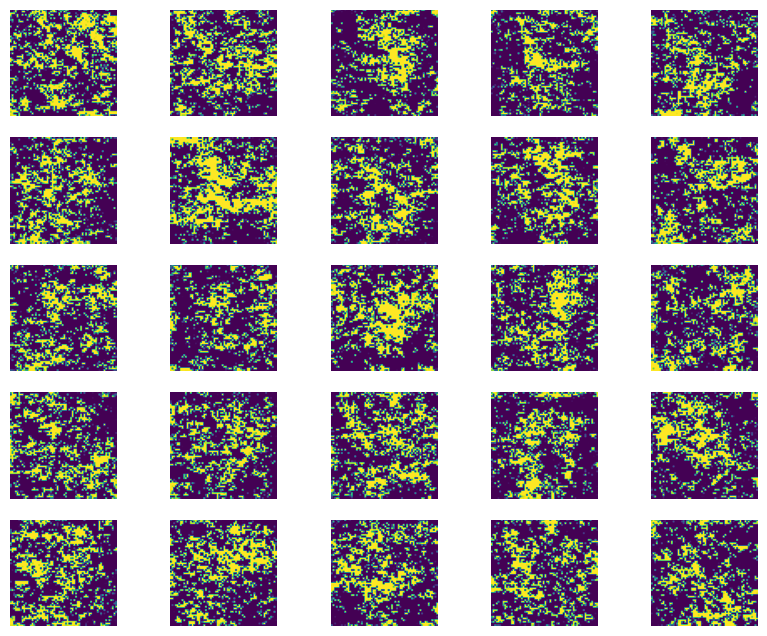

In [11]:

# Load the model
model = load_model('generator.h5')

# Generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
plt.figure(figsize=(10, 8))

# Plot the result
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[i, :, :, 0])
    #plt.imshow(X[i, :, :, 0], cmap='gray_r')
plt.show()